In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.model_selection import train_test_split

sns.set()
random_state = 123_456
np.random.seed(random_state)

error_tolerance_percentage = 2.5

/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [3]:
features = ['price']
df.shape

(1095, 6)

In [4]:
df = df[features]

In [5]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
df_train.shape

(985, 1)

In [6]:
df_test.shape

(110, 1)

In [7]:
# df_train.describe()

In [8]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [9]:
should_standard_scale = True

if should_standard_scale:
#     ct = make_column_transformer((MinMaxScaler(), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='box-cox'), features), verbose=True)
    ct = make_column_transformer((PowerTransformer(method='yeo-johnson'), features), verbose=True)

    result = ct.fit_transform(df_train)
    df_temp = pd.DataFrame(result, columns=features, index=df_train.index)

    for column in features:
        del df_train[column]

    df_train = df_train.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    
    result = ct.transform(df_test)
    df_temp = pd.DataFrame(result, columns=features, index=df_test.index)

    for column in features:
        del df_test[column]

    df_test = df_test.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    del df_temp
    
    scaler = ct.transformers_[0][1]

[ColumnTransformer]  (1 of 1) Processing powertransformer, total=   0.0s


In [10]:
df_train[:5]

price
2017-01-01 -1.152927
2017-01-02 -0.986197
2017-01-03 -1.223351
2017-01-04 -0.069118
2017-01-05  0.271453

In [11]:
df_test[:5]

price
2019-09-13  1.720894
2019-09-14  1.466291
2019-09-15  1.425083
2019-09-16  1.408589
2019-09-17  1.226731

In [12]:
y_train = df_train.price.shift(-1)
y_train.drop(y_train[y_train.index == '2019-09-12'].index, inplace=True)
df_train.drop(df_train[df_train.index == '2019-09-12'].index, inplace=True)
y_train[:5]

2017-01-01   -0.986197
2017-01-02   -1.223351
2017-01-03   -0.069118
2017-01-04    0.271453
2017-01-05   -0.180434
Freq: D, Name: price, dtype: float64

In [13]:
y_test = df_test.price.shift(-1)
y_test.drop(y_test[y_test.index == '2019-12-31'].index, inplace=True)
df_test.drop(df_test[df_test.index == '2019-12-31'].index, inplace=True)
y_test[:5]

2019-09-13    1.466291
2019-09-14    1.425083
2019-09-15    1.408589
2019-09-16    1.226731
2019-09-17    1.019117
Freq: D, Name: price, dtype: float64

In [14]:
df_train.shape

(984, 1)

In [15]:
df_test.shape

(109, 1)

In [16]:
y_train.shape

(984,)

In [17]:
y_test.shape

(109,)

In [18]:
X_train = df_train.values
X_train = np.reshape(X_train, (df_train.shape[0], 1, 1))
X_train.shape

(984, 1, 1)

In [19]:
X_test = df_test.values
X_test = np.reshape(X_test, (df_test.shape[0], 1, 1))
X_test.shape

(109, 1, 1)

In [20]:
y_train = y_train.values

In [21]:
y_test = y_test.values

In [22]:
model = Sequential()

In [23]:
# model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]),
#                dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
#                kernel_initializer='random_uniform'))

# model.add(Dropout(0.4))
# model.add(LSTM(60, dropout=0.0))
# model.add(Dropout(0.4))
# model.add(Dense(20,activation='relu'))
# model.add(Dense(1,activation='sigmoid'))

# optimizer = optimizers.RMSprop(lr=0.0001)
# model.compile(loss='mean_squared_error', optimizer=optimizer)

In [24]:
model.add(LSTM(128, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 128)                  66560     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train, epochs=16, verbose=1, batch_size=1, shuffle=False, 
                    validation_data=(X_test, y_test))

Train on 984 samples, validate on 109 samples
Epoch 1/16
984/984 [==============================] - 2s 2ms/step - loss: 0.1009 - val_loss: 0.0796
Epoch 2/16
984/984 [==============================] - 1s 994us/step - loss: 0.0584 - val_loss: 0.0747
Epoch 3/16
984/984 [==============================] - 1s 993us/step - loss: 0.0579 - val_loss: 0.0736
Epoch 4/16
984/984 [==============================] - 1s 990us/step - loss: 0.0578 - val_loss: 0.0734
Epoch 5/16
984/984 [==============================] - 1s 997us/step - loss: 0.0578 - val_loss: 0.0735
Epoch 6/16
984/984 [==============================] - 1s 997us/step - loss: 0.0577 - val_loss: 0.0736
Epoch 7/16
984/984 [==============================] - 1s 1ms/step - loss: 0.0577 - val_loss: 0.0739
Epoch 8/16
984/984 [==============================] - 1s 1ms/step - loss: 0.0577 - val_loss: 0.0741
Epoch 9/16
984/984 [==============================] - 1s 1ms/step - loss: 0.0576 - val_loss: 0.0743
Epoch 10/16
984/984 [=======================

In [27]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

In [28]:
y_hat = model.predict(X_test, batch_size=1)

In [29]:
y_hat = np.rint(scaler.inverse_transform(y_hat).reshape(1,-1)[0])

In [30]:
get_relative_accuracy(y_test, y_hat, error_tolerance_percentage)

0.8256880733944955

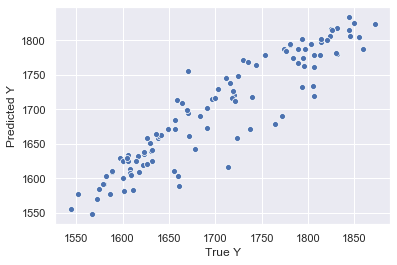

In [31]:
_ = sns.scatterplot(y_test, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()